In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device =  torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

torch.manual_seed(42)
np.random.seed(42)

mps


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.act = nn.SiLU()

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.fc2(h)
        return x + h

class ToyScoreModel(nn.Module):
    def __init__(self, d=100, hidden_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.input_proj = nn.Linear(d, hidden_dim)
        self.res1 = ResidualBlock(hidden_dim)
        self.res2 = ResidualBlock(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, d)
        self.act = nn.SiLU()

    def forward(self, x, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t_emb = self.time_mlp(t)
        h = self.input_proj(x)
        h = h + t_emb
        h = self.res1(h)
        h = self.res2(h)
        h = self.act(h)
        return self.output_proj(h)

def generate_ellipsoid_data(n_samples, d, m, sigma1_sq, sigma2_sq, f):
    """Génère y = F @ (z / ||z||) - variété non-linéaire (ellipsoïde)"""
    n1 = int(f * m)
    n2 = m - n1
    
    F1 = torch.randn(d, n1) * np.sqrt(sigma1_sq / m)
    F2 = torch.randn(d, n2) * np.sqrt(sigma2_sq / m)
    F = torch.cat([F1, F2], dim=1)
    
    z = torch.randn(n_samples, m)
    z_norms = torch.norm(z, dim=1, keepdim=True)
    z_tilde = z / (z_norms + 1e-8)
    
    y = z_tilde @ F.T
    
    return y.to(device), F.to(device)

def train_model(data, epochs=20000, batch_size=256, t_min=1e-4, t_max=1.0):
    """Entraîne le modèle de score avec Denoising Score Matching (VE)"""
    d = data.shape[1]
    model = ToyScoreModel(d=d, hidden_dim=256).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    n_samples = data.shape[0]
    
    model.train()
    for epoch in range(epochs):
        idx = torch.randint(0, n_samples, (batch_size,), device=device)
        x0 = data[idx]
        
        # t log-uniforme
        log_t = torch.rand(batch_size, 1, device=device) * (np.log(t_max) - np.log(t_min)) + np.log(t_min)
        t = torch.exp(log_t)
        
        # x_t = x_0 + sqrt(t) * eps
        eps = torch.randn_like(x0)
        sqrt_t = torch.sqrt(t)
        x_t = x0 + sqrt_t * eps
        
        # Score cible: -eps / sqrt(t)
        target = -eps / sqrt_t
        pred = model(x_t, t)
        
        # Loss pondérée par t
        loss = ((pred - target) ** 2 * t).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 5000 == 0:
            print(f"  Epoch {epoch:5d} | Loss: {loss.item():.6f}")
    
    return model

def get_orthogonal_perturbations(d, device):
    q, _ = torch.linalg.qr(torch.randn(d, d))
    return q.to(device)

def algorithm_2(model, x0, t0, eps=1e-3):
    """Algorithme 2 - Différences centrales"""
    model.eval()
    d = x0.numel()
    
    q_matrix = get_orthogonal_perturbations(d, device)
    x0_expanded = x0.unsqueeze(0).expand(d, -1)
    
    x_pos = x0_expanded + eps * q_matrix.T
    x_neg = x0_expanded - eps * q_matrix.T
    
    t_tensor = torch.full((d, 1), t0, device=device, dtype=torch.float32)
    
    with torch.no_grad():
        score_pos = model(x_pos, t_tensor)
        score_neg = model(x_neg, t_tensor)
    
    diff = (score_pos - score_neg) / (2 * eps)
    
    _, s_values, _ = torch.linalg.svd(diff)
    
    return s_values.cpu().numpy()

  Epoch     0 | Loss: 1.005523
  Epoch  5000 | Loss: 0.306908
  Epoch 10000 | Loss: 0.283064
  Computing spectrum for t=0.8...
  Computing spectrum for t=0.6...
  Computing spectrum for t=0.4...
  Computing spectrum for t=0.2...
  Computing spectrum for t=1e-05...
  Epoch     0 | Loss: 0.997642


/var/folders/mp/6ydgy90x40n7_78ydbhfk7780000gn/T/ipykernel_9727/3910105349.py:116: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  _, s_values, _ = torch.linalg.svd(diff)


  Epoch  5000 | Loss: 0.218555
  Epoch 10000 | Loss: 0.211585
  Computing spectrum for t=0.8...
  Computing spectrum for t=0.6...
  Computing spectrum for t=0.4...
  Computing spectrum for t=0.2...
  Computing spectrum for t=1e-05...


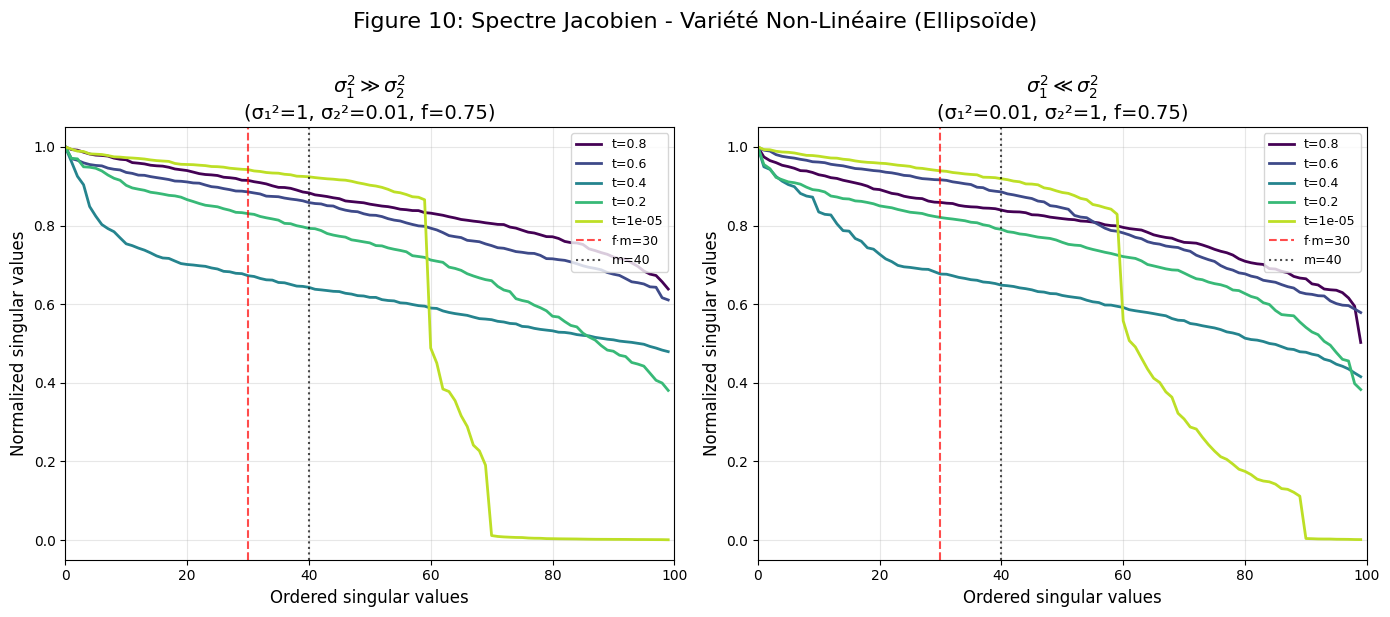

In [3]:
# Paramètres
d = 100
m = 40
f = 0.75
n_samples = 100000
epochs = 15000  # Augmenter pour meilleurs résultats

# Temps à tester (comme Figure 10)
t_values = [0.8, 0.6, 0.4, 0.2, 0.00001]

# LEFT: σ₁² >> σ₂² (σ₁²=1, σ₂²=0.01)
data_left, F_left = generate_ellipsoid_data(n_samples, d, m, sigma1_sq=1.0, sigma2_sq=0.01, f=f)
model_left = train_model(data_left, epochs=epochs)

x_test_left = data_left[0]
spectra_left = {}
for t in t_values:
    print(f"  Computing spectrum for t={t}...")
    s = algorithm_2(model_left, x_test_left, t)
    spectra_left[t] = s / s.max()

# RIGHT: σ₁² << σ₂² (σ₁²=0.01, σ₂²=1)
data_right, F_right = generate_ellipsoid_data(n_samples, d, m, sigma1_sq=0.01, sigma2_sq=1.0, f=f)
model_right = train_model(data_right, epochs=epochs)

x_test_right = data_right[0]
spectra_right = {}
for t in t_values:
    print(f"  Computing spectrum for t={t}...")
    s = algorithm_2(model_right, x_test_right, t)
    spectra_right[t] = s / s.max()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(t_values)))

# --- LEFT PLOT ---
ax = axes[0]
for (t, spectrum), color in zip(spectra_left.items(), colors):
    ax.plot(spectrum, color=color, linewidth=2, label=f't={t}')

ax.axvline(x=int(f*m), color='red', linestyle='--', alpha=0.7, label=f'f·m={int(f*m)}')
ax.axvline(x=m, color='black', linestyle=':', alpha=0.7, label=f'm={m}')

ax.set_xlabel("Ordered singular values", fontsize=12)
ax.set_ylabel("Normalized singular values", fontsize=12)
ax.set_title(r"$\sigma_1^2 \gg \sigma_2^2$" + f"\n(σ₁²=1, σ₂²=0.01, f={f})", fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0, d)

# --- RIGHT PLOT ---
ax = axes[1]
for (t, spectrum), color in zip(spectra_right.items(), colors):
    ax.plot(spectrum, color=color, linewidth=2, label=f't={t}')

ax.axvline(x=int(f*m), color='red', linestyle='--', alpha=0.7, label=f'f·m={int(f*m)}')
ax.axvline(x=m, color='black', linestyle=':', alpha=0.7, label=f'm={m}')

ax.set_xlabel("Ordered singular values", fontsize=12)
ax.set_ylabel("Normalized singular values", fontsize=12)
ax.set_title(r"$\sigma_1^2 \ll \sigma_2^2$" + f"\n(σ₁²=0.01, σ₂²=1, f={f})", fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0, d)

plt.suptitle("Figure 10: Spectre Jacobien - Variété Non-Linéaire (Ellipsoïde)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()